In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt

#fix SLL/notebook error using certfi (only necessary because I'm running in notebooks)
import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

#import data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url, index_col=0)

In [2]:
#the data requires some prep before visualizing, this function will be used to:
#1. create a copy of the df for one state
#2. ensures that date columns contain only numeric values
#3. calculates daily covid cases (used for questions 1, 2, and 3)
#4. smooths the noise in the data using a rolling window

#the columns containing dates are 12+
date_columns = df.columns[11:]

def prep_state_data (df, state, date_columns, rolling_window=7):
    df_state = df[df['Province_State'] == state].copy()
    df_state[date_columns] = (
        df_state[date_columns]
        .apply(pd.to_numeric, errors='coerce')
        .diff(axis=1)
        .fillna(0)
        .T 
        .rolling(window=rolling_window, min_periods=1)
        .mean()
        .T
    )
    return df_state.copy()

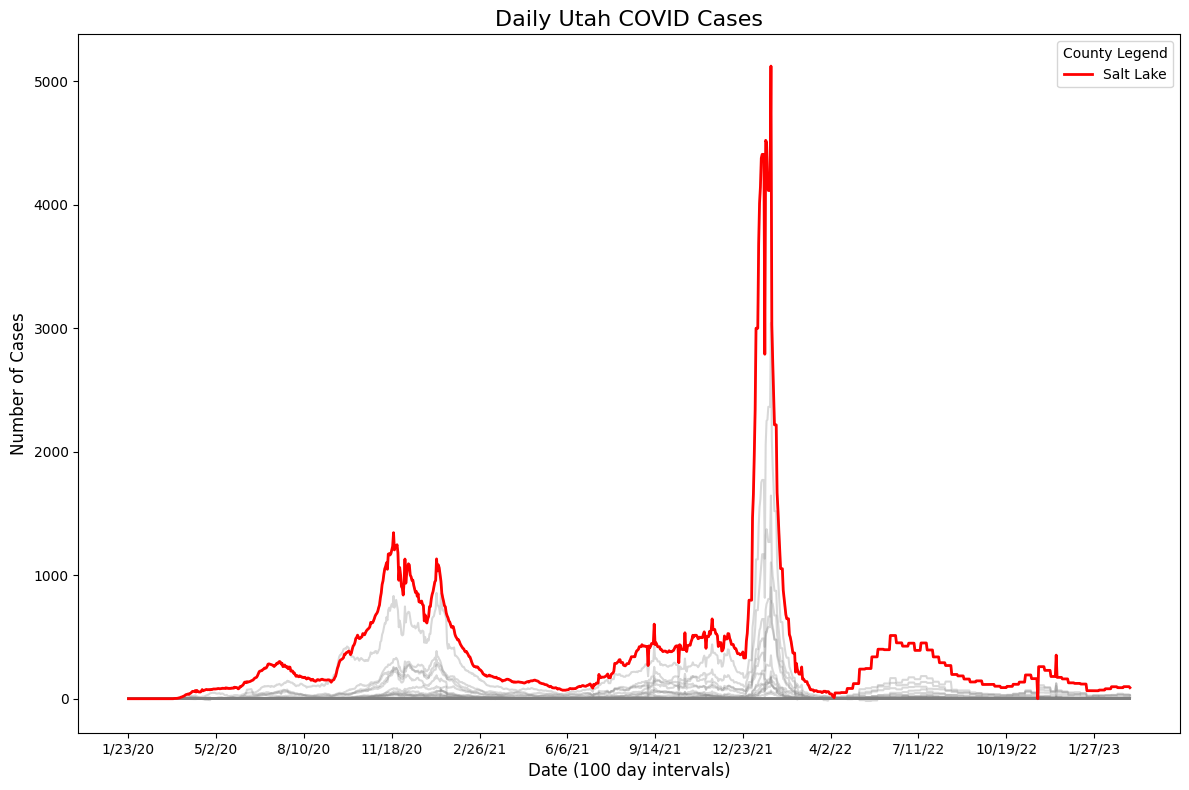

In [3]:
##1 Create a visualization that shows all of the counties in Utah as a time series. 

#call the function to isolate and prepare Utah data
df_utah = prep_state_data(df, 'Utah', date_columns)

#create plot
plt.figure(figsize=(12, 8))

#plot timeseries for all counties in grey
for element in df_utah['Admin2'].unique():
    df_county = df_utah[df_utah['Admin2'] == element]
    plt.plot(date_columns, df_county[date_columns].values.flatten(), color='grey', alpha=0.3)

#highlight a county in red
red_data = df_utah[df_utah['Admin2'] == 'Salt Lake']
plt.plot(date_columns, red_data[date_columns].values.flatten(), color='red', linewidth=2, label='Salt Lake')

#plot details
plt.legend(title="County Legend")
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Date (100 day intervals)', fontsize=12)
plt.xticks(ticks=date_columns[::100], labels=date_columns[::100], fontsize=10)
plt.title('Daily Utah COVID Cases', fontsize=16)
plt.tight_layout()
plt.show()

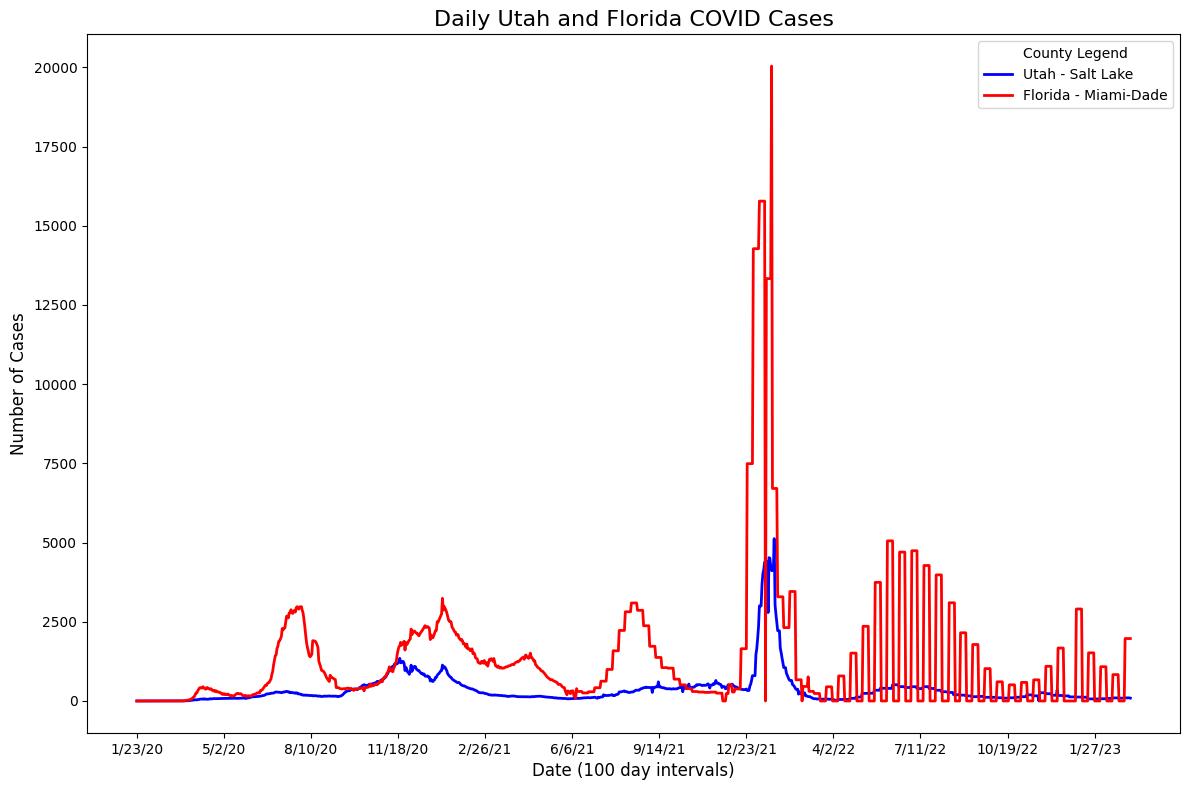

In [4]:
##2 Create a visualization that shows the contrast between the county in Utah/Florida with the most cases.

#call the function to isolate and prepare Florida data
df_florida = prep_state_data(df, 'Florida', date_columns)

#create a new column for the sums of each Utah and Floridas daily cases
df_utah['TotalCases'] = df_utah[date_columns].sum(axis=1)
df_florida['TotalCases'] = df_florida[date_columns].sum(axis=1)

#use the new column to find the counties with the most cases and isolate them
max_utah_county = df_utah.loc[df_utah['TotalCases'].idxmax()]['Admin2']
max_florida_county = df_florida.loc[df_florida['TotalCases'].idxmax()]['Admin2']

df_utah_max = df_utah.loc[df_utah['Admin2'] == max_utah_county]
df_florida_max = df_florida.loc[df_florida['Admin2'] == max_florida_county]

#create plot
plt.figure(figsize=(12, 8))

#plot the Utah and Florida county with the most cases
plt.plot(date_columns , df_utah_max[date_columns ].values[0], color='blue', linewidth=2, label=f"Utah - {max_utah_county}")
plt.plot(date_columns , df_florida_max[date_columns ].values[0], color='red', linewidth=2, label=f"Florida - {max_florida_county}")

#plot details
plt.legend(title="County Legend")
plt.ylabel('Number of Cases', fontsize=12)
plt.xlabel('Date (100 day intervals)', fontsize=12)
plt.xticks(ticks=date_columns [::100], labels=date_columns [::100], fontsize=10)
plt.title('Daily Utah and Florida COVID Cases', fontsize=16)
plt.tight_layout()
plt.show()

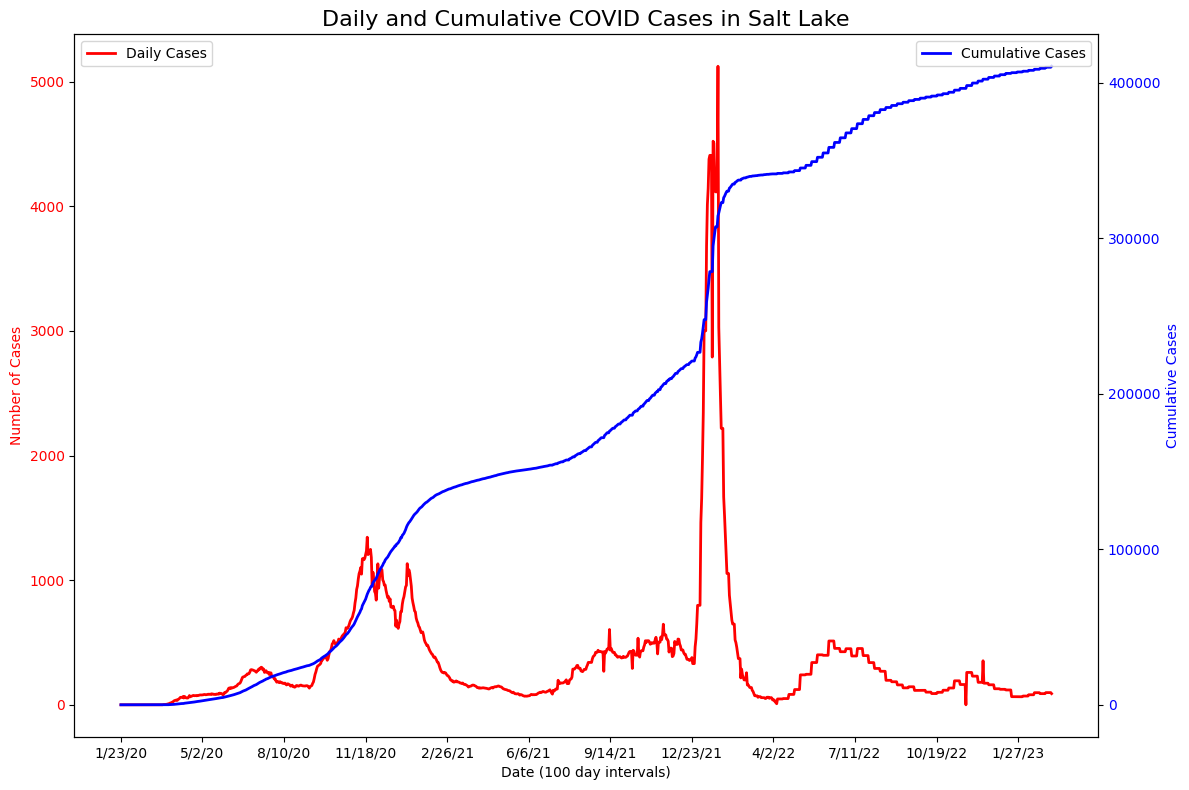

In [5]:
##3 Create a visualization that shows BOTH the running total of cases for a single county AND the daily new cases. 

#create another copy of the Utah data without using the function for cumulative data
df_original_utah =df[df['Province_State'] == 'Utah'].copy()

#create plot for Salt Lake county

fig, ax1 = plt.subplots(figsize=(12, 8))
daily_data = df_utah[df_utah['Admin2'] == 'Salt Lake']
ax1.plot(date_columns, daily_data[date_columns].values.flatten(), color='red', linewidth=2, label='Daily Cases')
ax1.set_xlabel('Date (100 day intervals)')
ax1.set_ylabel('Daily Cases', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx() 
cumulative_data = df_original_utah[df_original_utah['Admin2'] == 'Salt Lake'] 
ax2.plot(date_columns, cumulative_data[date_columns].values.flatten(), color='blue', linewidth=2, label='Cumulative Cases')
ax2.set_ylabel('Cumulative Cases', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

#plot details
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(ticks=date_columns[::100], labels=date_columns[::100], fontsize=10)
plt.title('Daily and Cumulative COVID Cases in Salt Lake', fontsize=16)
plt.tight_layout()
plt.show()

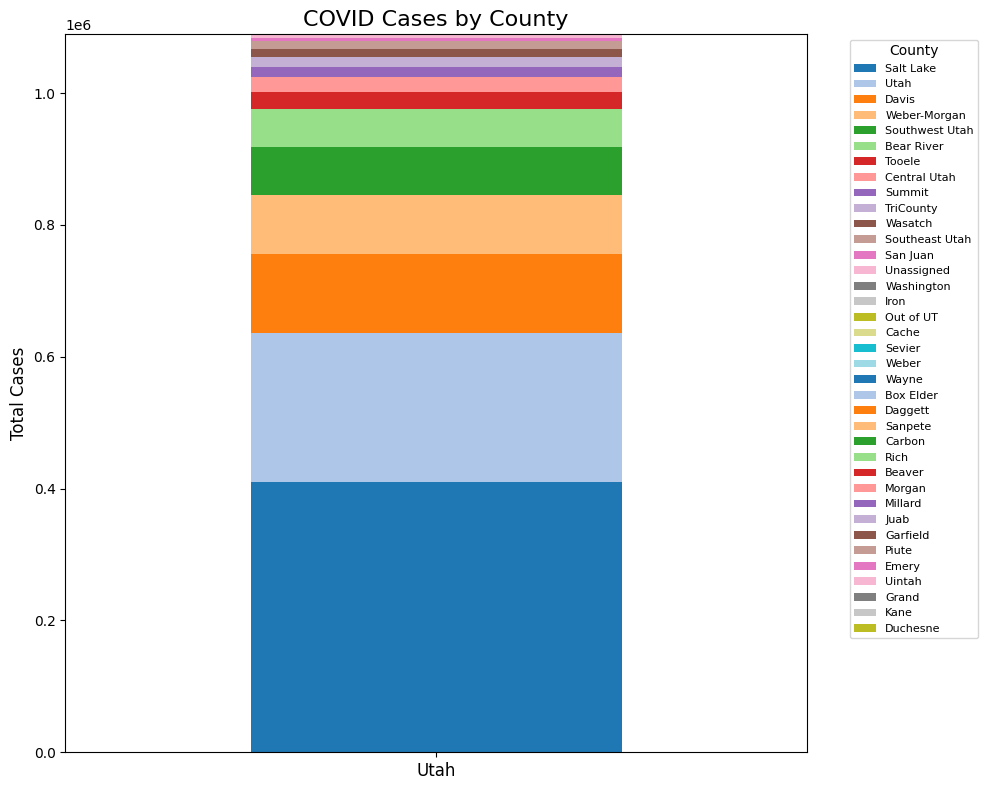

In [6]:
##4 Create a visualization that shows a stacked bar chart of county contributions to a given state's total cases. 

#used the sum column created earlier, sort counties by sum
df_sort = df_utah.sort_values(by='TotalCases', ascending=False)

#create plot
fig, ax = plt.subplots(figsize=(10, 8))

#plot stacked bar chart
df_sort.set_index('Admin2')[['TotalCases']].T.plot(kind='bar', stacked=True, ax=ax, color=plt.cm.tab20.colors)

# Set titles and labels
plt.legend(title="County", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.ylabel('Total Cases', fontsize=12)
plt.xticks([0], ['Utah'], rotation=0, fontsize=12)
plt.title('COVID Cases by County', fontsize=16)
plt.tight_layout()
plt.show()

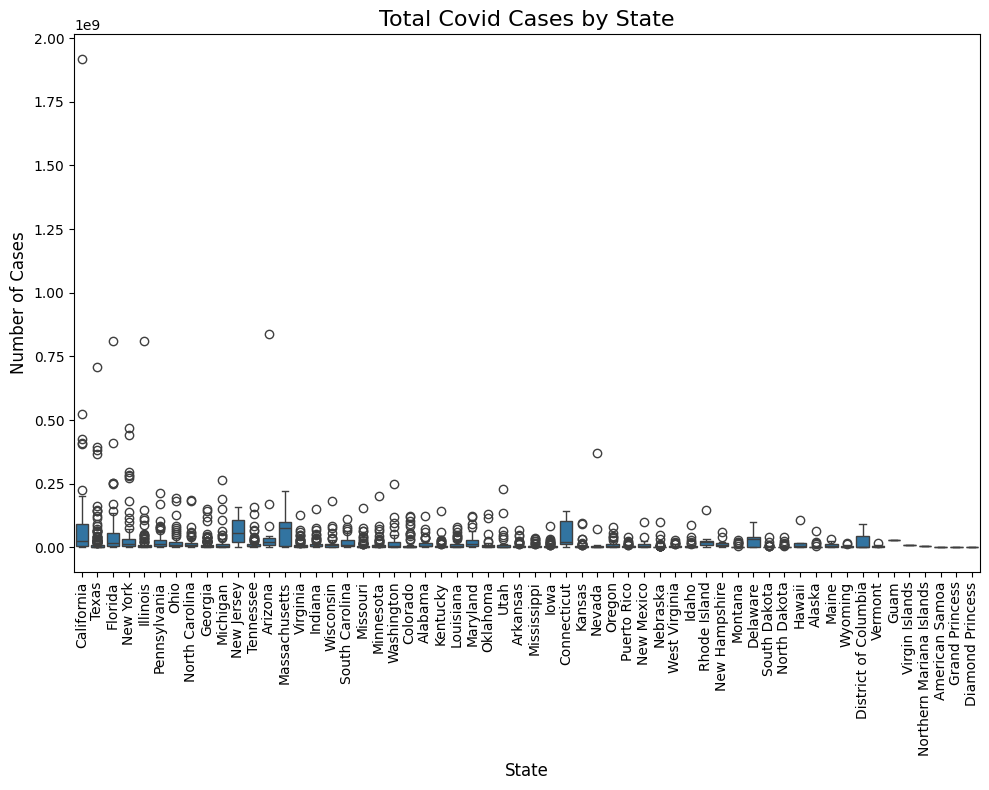

In [7]:
##Extra Credit
import seaborn as sns

#sum data from the whole df for the sum column
df['TotalCases'] = df[date_columns].sum(axis=1)
#group by state and sort in order
state_total_cases = df.groupby('Province_State')['TotalCases'].sum().sort_values(ascending=False)

#create plot
plt.figure(figsize=(10, 8))

sns.boxplot(
    data=df,
    x='Province_State', 
    y='TotalCases',
    order=state_total_cases.index
)

#plot details
plt.title('Total Covid Cases by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()